# 4.  Doc2Vec Approach

## A. Doc2Vec Model

In [2]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from random import shuffle
from collections import OrderedDict

import multiprocessing

import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1

cores = multiprocessing.cpu_count()
print(cores)

model_feat_size = 100

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
    
    def extract_sentences(self):
        self.sentences = []
        for sr, pr in self.sources.items():
            with utils.smart_open(sr) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(),
                                                          [pr + '_%s' % item_no]))
    
    def sentences_perm(self):
        shuffle(self.sentences)
        return self.sentences        

4


In [3]:
sources = {'test_bad_reviews.txt':'TE_B',
           'test_good_reviews.txt':'TE_G',
           'train_bad_reviews.txt':'TR_B',
           'train_good_reviews.txt':'TR_G'}

In [125]:
# This will be a list of all sentences
sentences = LabeledLineSentence(sources)
sentences.extract_sentences()

![Mikov's params for IMDB](http://nbviewer.jupyter.org/github/fbkarsdorp/doc2vec/blob/master/quoc-response.png)

In [8]:
# Creating models using params from Mikolov above and here:
# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb
# Number of features reduced to 100 from 400 to reduce training time
single_models = [
    # PV-DM with concatenation (window is on both side so actually *2)
    Doc2Vec(dm=1, dm_concat=1, size=model_feat_size, window=5, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DBOW
    Doc2Vec(dm=0, size=model_feat_size, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DM with averaging
    Doc2Vec(dm=1, dm_mean=1, size=model_feat_size, window=10, negative=5, hs=0, min_count=2, workers=cores)
]

single_models[0].build_vocab(sentences.sentences)
print(single_models[0])

# Use learnt vocab for other models
for mod in single_models[1:]:
    mod.reset_from(single_models[0])
    print(mod)

nms = ['dm_concat', 'dbow', 'dm_averaging']
models = OrderedDict((str(name), model) for model, name in zip(single_models, nms))

Doc2Vec(dm/c,d100,n5,w5,mc2,t24)
Doc2Vec(dbow,d100,n5,mc2,t24)
Doc2Vec(dm/m,d100,n5,w10,mc2,t24)


In [9]:
# Also use concatenated vectors from each model
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

models['dbow_dmm'] = ConcatenatedDoc2Vec([single_models[1], single_models[2]])
models['dbow_dmc'] = ConcatenatedDoc2Vec([single_models[1], single_models[0]])

print(models)

OrderedDict([('dm_concat', <gensim.models.doc2vec.Doc2Vec object at 0x000001F9B8B09EF0>), ('dbow', <gensim.models.doc2vec.Doc2Vec object at 0x000001F9B8B09F28>), ('dm_averaging', <gensim.models.doc2vec.Doc2Vec object at 0x000001F9B8B09F98>), ('dbow_dmm', <gensim.test.test_doc2vec.ConcatenatedDoc2Vec object at 0x000001F9B8AF5F60>), ('dbow_dmc', <gensim.test.test_doc2vec.ConcatenatedDoc2Vec object at 0x000001F9B8AF5F28>)])


In [ ]:
# Train (five) model:
for nme, model in models.items():
       
    alpha, min_alpha, epochs = (0.025, 0.001, 20)
    alpha_delta = (alpha - min_alpha) / epochs

    print("Training model: %s" % nme)

    for epoch in range(epochs):

        print("Training epoch: %d" % (epoch+1))

        model.alpha, model.min_alpha = alpha, alpha
        model.train(sentences.sentences_perm())
        alpha -= alpha_delta

    print("Finished training model: %s" % nme)

In [11]:
del sentences

In [87]:
# Save the dictionary of models
import pickle

####################################################################
# Save
####################################################################
pickle.dump(models, open("dm_800d_window_2.pickle","wb"))

In [4]:
import pickle

####################################################################
# Load
####################################################################

models = pickle.load(open("trained_models_100d_1mill.pickle","rb"))

## B. Classification

In [5]:
import numpy
from sklearn.linear_model import LogisticRegression

# Check sizes
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


# Dictionary of file-lengths
file_lengths = {}
for k,v in sources.items():
    file_lengths[v] = file_len(k)
print(file_lengths)

{'TE_B': 500208, 'TR_G': 499581, 'TR_B': 499792, 'TE_G': 500419}


In [20]:
for nme, model in models.items():
    
    if "Concatenated" in str(model):
        print("Array shape x 2")
        array_shape = 2*model_feat_size
    else:
        array_shape = model_feat_size
    
    print(nme, model)
    
    # Train vectors
    no_training = file_lengths['TR_G'] + file_lengths['TR_B']
    #print("%d for training" % no_training)

    train_arrays = numpy.zeros((no_training, array_shape))
    train_labels = numpy.concatenate((numpy.ones(file_lengths['TR_G']),
                                      numpy.zeros(file_lengths['TR_B'])))

    for i in range(file_lengths['TR_G']):
        train_arrays[i] = model.docvecs['TR_G_' + str(i)]
    
    for i in range(file_lengths['TR_B']):
        train_arrays[file_lengths['TR_G'] + i] = model.docvecs['TR_B_' + str(i)]

    #assert len(train_arrays) == len(train_labels)

    classifier = LogisticRegression()  
    classifier.fit(train_arrays, train_labels)
    

    del train_arrays
    del train_labels

    # Test vectors
    no_testing = file_lengths['TE_G'] + file_lengths['TE_B']
    #print("%d for testing" % no_testing)

    test_arrays = numpy.zeros((no_testing, array_shape))
    test_labels = numpy.concatenate((numpy.ones(file_lengths['TE_G']),
                                      numpy.zeros(file_lengths['TE_B'])))
         
    
    for i in range(file_lengths['TE_G']):
        test_arrays[i] = model.docvecs['TE_G_' + str(i)]

    for i in range(file_lengths['TE_B']):
        test_arrays[file_lengths['TE_G'] + i] = model.docvecs['TE_B_' + str(i)]

    #assert len(test_arrays) == len(test_labels)
    acc = classifier.score(test_arrays, test_labels)
    
    # Does class affect accuracy?
    correct = classifier.predict(test_arrays) == test_labels
    print("Accuracy for positives: %.5f" % (sum(correct[test_labels==1])/file_lengths['TE_G']))
    print("Accuracy for negatives: %.5f" % (sum(correct[test_labels!=1])/file_lengths['TE_B']))

    print("Model: %s scored: %.5f" % (nme, acc))
    # 0.85895 highest from ConcatenatedDoc2Vec(dbow, dmm)

dm_concat Doc2Vec(dm/c,d100,n5,w5,mc2,t24)
Accuracy for positives: 0.77766
Accuracy for negatives: 0.78328
Model: dm_concat scored: 0.78047
dbow Doc2Vec(dbow,d100,n5,mc2,t24)
Accuracy for positives: 0.84637
Accuracy for negatives: 0.86181
Model: dbow scored: 0.85409
dm_averaging Doc2Vec(dm/m,d100,n5,w10,mc2,t24)
Accuracy for positives: 0.81473
Accuracy for negatives: 0.80937
Model: dm_averaging scored: 0.81205
Array shape x 2
dbow_dmm <gensim.test.test_doc2vec.ConcatenatedDoc2Vec object at 0x00000245BB78A358>
Accuracy for positives: 0.85348
Accuracy for negatives: 0.86442
Model: dbow_dmm scored: 0.85895
Array shape x 2
dbow_dmc <gensim.test.test_doc2vec.ConcatenatedDoc2Vec object at 0x00000245BB796400>
Accuracy for positives: 0.84938
Accuracy for negatives: 0.86344
Model: dbow_dmc scored: 0.85641


```
{'TE_B': 500208, 'TE_G': 500419, 'TR_G': 499581, 'TR_B': 499792}
dm_concat Doc2Vec(dm/c,d100,n5,w5,mc2,t24)
999373 for training
1000627 for testing
Model: dm_concat scored: 0.78047
dbow Doc2Vec(dbow,d100,n5,mc2,t24)
999373 for training
1000627 for testing
Model: dbow scored: 0.85409
dm_averaging Doc2Vec(dm/m,d100,n5,w10,mc2,t24)
999373 for training
1000627 for testing
Model: dm_averaging scored: 0.81205
Array shape x 2
dbow_dmm <gensim.test.test_doc2vec.ConcatenatedDoc2Vec object at 0x000001F7074922B0>
999373 for training
1000627 for testing
Model: dbow_dmm scored: 0.85895
Array shape x 2
dbow_dmc <gensim.test.test_doc2vec.ConcatenatedDoc2Vec object at 0x000001F707492390>
999373 for training
1000627 for testing
Model: dbow_dmc scored: 0.85641
```

In [92]:
# What does a sample document vector look like?
model.docvecs['TE_G_10']

array([ 2.56832957,  1.2058115 ,  0.14491647, -0.42551604, -0.38818172,
       -0.8952595 , -0.4061074 ,  1.6264652 ,  0.57415462, -1.82958436,
        1.04183209,  0.66710657,  1.49038315, -1.95077193,  0.9098739 ,
        0.85745955,  1.43841267,  1.03374803,  0.68891966, -1.03387189,
        1.8800143 ,  1.0016433 ,  0.15377448, -0.13892122,  0.62905884,
        1.17400193,  0.30953103, -1.33326066, -1.6362499 , -1.03263128,
       -1.9761641 , -0.5444386 , -0.0458766 ,  1.72448826,  0.46611884,
       -1.50342023,  1.06823838,  0.83525628,  0.02131413,  0.11638412,
        1.10794115, -1.03421974, -0.37249202,  0.74126559, -2.26668239,
        1.09970188,  2.04381251, -1.00660169, -0.10463743,  1.28817487,
        0.65644276,  1.72466075, -1.62890887,  0.55496752, -2.7380898 ,
        0.65241426,  0.21561557,  0.00379093, -0.5218727 , -0.49999937,
       -3.32112288,  0.03845607, -0.41876355,  0.70093024,  2.54490423,
       -0.04950583, -0.11358964,  2.10094333,  1.87797546,  1.53

In [21]:
## What would a Word2Vec approach look-like?
# Since Doc2Vec has Word2Vec inside the hood ...

# Use word vectors from model (and not doc vectors)
model = models['dm_averaging']
model_vocab_set = set(model.index2word)
array_shape = 100

# Return a feature using word vectors
def word2vec_feature_extraction(fname, w2v_model, vocab):
    with open(fname) as f:
        for line in f:

            feat_vec = np.zeros((array_shape,),dtype="float32")
            word_count = 0
            
            for word in utils.to_unicode(line).split():
                if word in vocab:
                    feat_vec = np.add(feat_vec, w2v_model[word])
                    word_count += 1
                    
            if word_count > 0:
                yield np.divide(feat_vec, word_count)
            
print("Training ...")

train_arrays = []
train_labels = []

print("Getting features from good reviews")
for x in word2vec_feature_extraction('train_good_reviews.txt', model, model_vocab_set):
    train_arrays.append(x)
    train_labels.append(1)

print("Getting features from bad reviews")
for c, x in enumerate(word2vec_feature_extraction('train_bad_reviews.txt', model, model_vocab_set)):
    train_arrays.append(x)
    train_labels.append(0)
    
print("Training Classifier")
classifier = LogisticRegression()  
classifier.fit(train_arrays, train_labels)

del train_arrays
del train_labels

print("Testing ...")

test_arrays = []
test_labels = []

print("Getting features from good reviews")
for x in word2vec_feature_extraction('test_good_reviews.txt', model, model_vocab_set):
    test_arrays.append(x)
    test_labels.append(1)

print("Getting features from bad reviews")
for x in word2vec_feature_extraction('test_bad_reviews.txt', model, model_vocab_set):
    test_arrays.append(x)
    test_labels.append(0)

print("Scoring classifier")
acc = classifier.score(test_arrays, test_labels)

print("Model scored: %.5f" % acc)

Training ...
Getting features from good reviews
Getting features from bad reviews
Training Classifier
Testing ...
Getting features from good reviews
Getting features from bad reviews
Scoring classifier
Model scored: 0.84118


## C. Play around with the features of the model

In [6]:
model = models['dm_averaging']

In [7]:
print(len(model.vocab))

247718


In [90]:
# Similar words:
# cosine similarity between a simple mean of the projection weight vectors 
# of the given words and the vectors for each word in the model

In [91]:
model.most_similar('movie')

[('film', 0.9756659269332886),
 ('game', 0.9631760120391846),
 ('book', 0.9562268257141113),
 ('novel', 0.9456548690795898),
 ('series', 0.9344912767410278),
 ('story', 0.9277447462081909),
 ('toy', 0.9255129098892212),
 ('documentary', 0.9239569306373596),
 ('album', 0.9229424595832825),
 ('product', 0.9229174256324768)]

In [37]:
model.most_similar('book')

[('novel', 0.9667423963546753),
 ('film', 0.9627326726913452),
 ('movie', 0.9562268257141113),
 ('product', 0.9447879791259766),
 ('game', 0.9428784251213074),
 ('item', 0.9405743479728699),
 ('series', 0.9339053630828857),
 ('cd', 0.9305703639984131),
 ('cookbook', 0.924953818321228),
 ('unit', 0.9230896830558777)]

In [38]:
model.most_similar('spielberg')

[('brust', 0.7509414553642273),
 ('seagal', 0.6961789131164551),
 ('godard', 0.6865265369415283),
 ('altman', 0.6823572516441345),
 ('costner', 0.6704180240631104),
 ('alten', 0.6646450757980347),
 ('hitchcock', 0.6628223657608032),
 ('spielburg', 0.6588513851165771),
 ('bowie', 0.6585037708282471),
 ('paolini', 0.6476680040359497)]

In [39]:
model.most_similar('disappointed')

[('dissapointed', 0.9665608406066895),
 ('dissappointed', 0.9549894332885742),
 ('disapointed', 0.9537227153778076),
 ('upset', 0.8508213758468628),
 ('impressed', 0.8426313400268555),
 ('displeased', 0.8382212519645691),
 ('disspointed', 0.8305480480194092),
 ('diappointed', 0.8276960849761963),
 ('disapponted', 0.8072155714035034),
 ('disppointed', 0.7938259243965149)]

** However, look at some of the most similar results to these: **

In [40]:
model.most_similar('good')

[('great', 0.8415285348892212),
 ('nice', 0.8255696296691895),
 ('decent', 0.8067948818206787),
 ('bad', 0.7878735065460205),
 ('satisfactory', 0.7774009704589844),
 ('reasonable', 0.7503374814987183),
 ('terrific', 0.7394672632217407),
 ('stellar', 0.7384458780288696),
 ('weak', 0.7360069155693054),
 ('lousy', 0.7356691956520081)]

In [41]:
model.most_similar('liked')
# ('hated', 0.940513014793396)
# Notice that the past-tense is captured (loved more likely than love)

[('loved', 0.9617341160774231),
 ('enjoyed', 0.9531521797180176),
 ('hated', 0.940513014793396),
 ('love', 0.9257104396820068),
 ('hate', 0.8870297074317932),
 ('knew', 0.8754450082778931),
 ('disliked', 0.8680945038795471),
 ('saw', 0.8665635585784912),
 ('returned', 0.8661980032920837),
 ('enjoy', 0.8642623424530029)]

In [43]:
model.most_similar('amazing')

[('awesome', 0.958543062210083),
 ('incredible', 0.9484298229217529),
 ('outstanding', 0.9301931262016296),
 ('awsome', 0.8869935870170593),
 ('excellent', 0.883213460445404),
 ('exceptional', 0.8818068504333496),
 ('awful', 0.8477048873901367),
 ('astounding', 0.8337091207504272),
 ('extraordinary', 0.8214305639266968),
 ('astonishing', 0.8043204545974731)]

** We have no distinction between synonyms and antonyms. For me this seems crucial ... **

** Basically, similarity('bad', 'good') > similarity('good', 'reasonable') **

In [55]:
# ('queen', 0.6658217906951904)
model.most_similar(positive=['king','woman'], negative=['man'])

[('prince', 0.6947972774505615),
 ('queen', 0.6658217906951904),
 ('bishop', 0.6533105969429016),
 ('baxter', 0.6368122100830078),
 ('weber', 0.6214838027954102),
 ('goliath', 0.6017906665802002),
 ('pope', 0.5975253582000732),
 ('elton', 0.5942682027816772),
 ('legend', 0.5937572121620178),
 ('stone', 0.5932419300079346)]

In [44]:
# Similar documents:

In [45]:
def line_from_file(fname, line_no):
    with open(fname) as f:
        for i, l in enumerate(f):
            if i == line_no:
                return l
            
print(line_from_file('train_good_reviews.txt',0))

it is and does exactly what the description said it would be and would do . couldn ' t be happier with it .



In [46]:
model.docvecs.most_similar('TR_G_0')

[('TR_G_360872', 0.8071361780166626),
 ('TR_B_234248', 0.802955687046051),
 ('TR_G_385106', 0.7977914214134216),
 ('TR_B_128954', 0.7973953485488892),
 ('TR_G_322557', 0.7963820695877075),
 ('TE_G_122163', 0.7958847880363464),
 ('TE_G_304226', 0.794230580329895),
 ('TE_B_395691', 0.7940493822097778),
 ('TE_G_203933', 0.7899248600006104),
 ('TE_G_1155', 0.7880555391311646)]

In [47]:
print(line_from_file('train_good_reviews.txt', 360872))

very compact and easy to use . does what they said it would do . i would recommend it to a friend .



`it is and does exactly what the description said it would be and would do . couldn ' t be happier with it .`

v.s.

`very compact and easy to use . does what they said it would do . i would recommend it to a friend .`

In [ ]:
# Infer documents

In [84]:
inferred_example = model.infer_vector(['this','broke','straight','out','of','the','box'])
model.docvecs.most_similar([inferred_example], topn=5)

[('TE_B_435805', 0.8324828147888184),
 ('TE_G_109719', 0.8270643353462219),
 ('TR_G_95891', 0.8243824243545532),
 ('TR_G_276590', 0.822350025177002),
 ('TE_B_200194', 0.8196755647659302)]

In [85]:
# ('TR_G_101591', 0.8730407953262329)
print(line_from_file('test_bad_reviews.txt', 435805))

this did not work .



`['this','broke','straight','out','of','the','box']`

v.s.

`this did not work .`

## D. Visualisations

### Word Vectors

In [42]:
# Re-create training vectors:
model = models['dm_averaging']
modle = Doc2Vec.load_word2vec_format('GoogleNews.bin', binary=True)

# words
model.syn0.shape

(247718, 100)

In [43]:
wrds = list(model.index2word)
shuffle(wrds)
wrds = wrds[:200]
X = [model[wrd] for wrd in wrds]
print(wrds)

['hair', 'sashiko', 'balram', 'timken', 'burnley', 'anyon', 'caressing', 'untilthe', 'slaughtered', 'diaphrams', 'elvises', 'crypts', 'niecey', 'xerxes', 'yabuca', 'assembling', 'boc', 'automagic', 'jena', 'florets', 'thevortex', 'unbareable', 'phiz', 'restive', 'biying', 'houseboats', 'plugoks', 'chemsitry', 'detrata', 'previouse', 'mch', 'ofnatural', 'driper', 'retriever', 'replies', 'summations', 'tokico', 'touptek', 'toyed', 'rancidityhas', 'irrelivent', 'unfortunatally', 'erez', 'gindin', 'perameters', 'tarnoff', 'partof', 'ihv', 'tann', 'idling', 'flemzy', 'mudded', 'leasts', 'rookery', 'chipseal', 'microfracture', 'bepalen', 'andspiritual', 'moneii', 'psychportal', 'mythique', 'bioastin', 'terrorista', 'accura', 'blonde', 'cohosh', 'dount', 'byo', 'gewgaws', 'asas', 'morefor', 'supertalent', 'yeat', 'atliens', 'ashen', 'liens', 'phonolog', 'seiyuu', 'pmsing', 'sageo', 'eruptum', 'brid', 'inaccessibly', 'technocrats', 'reich', 'especiallly', 'ejaculate', 'inspirtional', 'chasis',

In [44]:
%pylab inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, verbose=1)
X_r = tsne.fit_transform(X)

Populating the interactive namespace from numpy and matplotlib
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 4.391341
[t-SNE] Error after 100 iterations with early exaggeration: 2.023785
[t-SNE] Error after 300 iterations: 1.827049


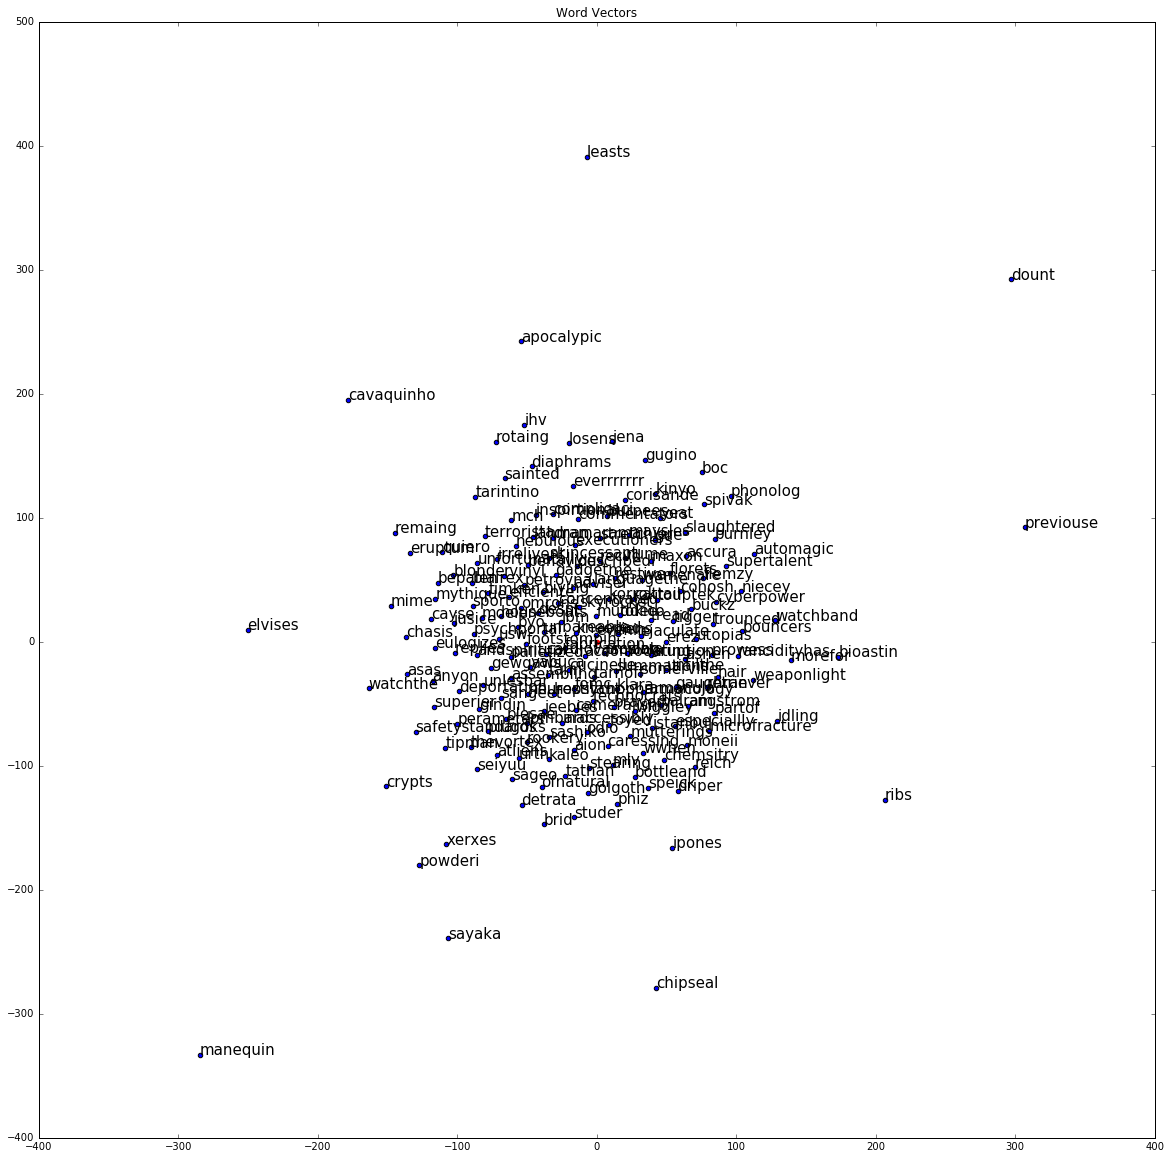

In [45]:
plt.figure(figsize=(20,20))

for i, d in enumerate(wrds):
    plt.scatter(X_r[i, 0], X_r[i, 1], alpha=1)
    plt.annotate(d, (X_r[i, 0], X_r[i, 1]), fontsize=15)
    #plt.xlim([-0.0003,0.0003])
    #plt.ylim([-0.0003,0.0003])

# Origin
#plt.legend()
plt.scatter(0,0,alpha=1,color='r')
    
plt.title('Word Vectors')

### PCA and tSNE on doc vectors

In [10]:
import numpy 

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

file_lengths = {}
for k,v in sources.items():
    file_lengths[v] = file_len(k)

no_training = file_lengths['TR_G'] + file_lengths['TR_B']
print("%d for training" % no_training)

train_arrays = numpy.zeros((no_training, 100))
train_labels = numpy.concatenate((numpy.ones(file_lengths['TR_G']),
                                  numpy.zeros(file_lengths['TR_B'])))

for i in range(file_lengths['TR_G']):
    train_arrays[i] = model.docvecs['TR_G_' + str(i)]

for i in range(file_lengths['TR_B']):
    train_arrays[file_lengths['TR_G'] + i] = model.docvecs['TR_B_' + str(i)]

# Select 1000 examples to visualise
idx = np.random.choice(np.arange(len(train_arrays)), 1000, replace=False)

X = train_arrays[idx]
y = train_labels[idx]

999373 for training


Populating the interactive namespace from numpy and matplotlib
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.767077
[t-SNE] Error after 100 iterations with early exaggeration: 1.229986
[t-SNE] Error after 175 iterations: 1.213885


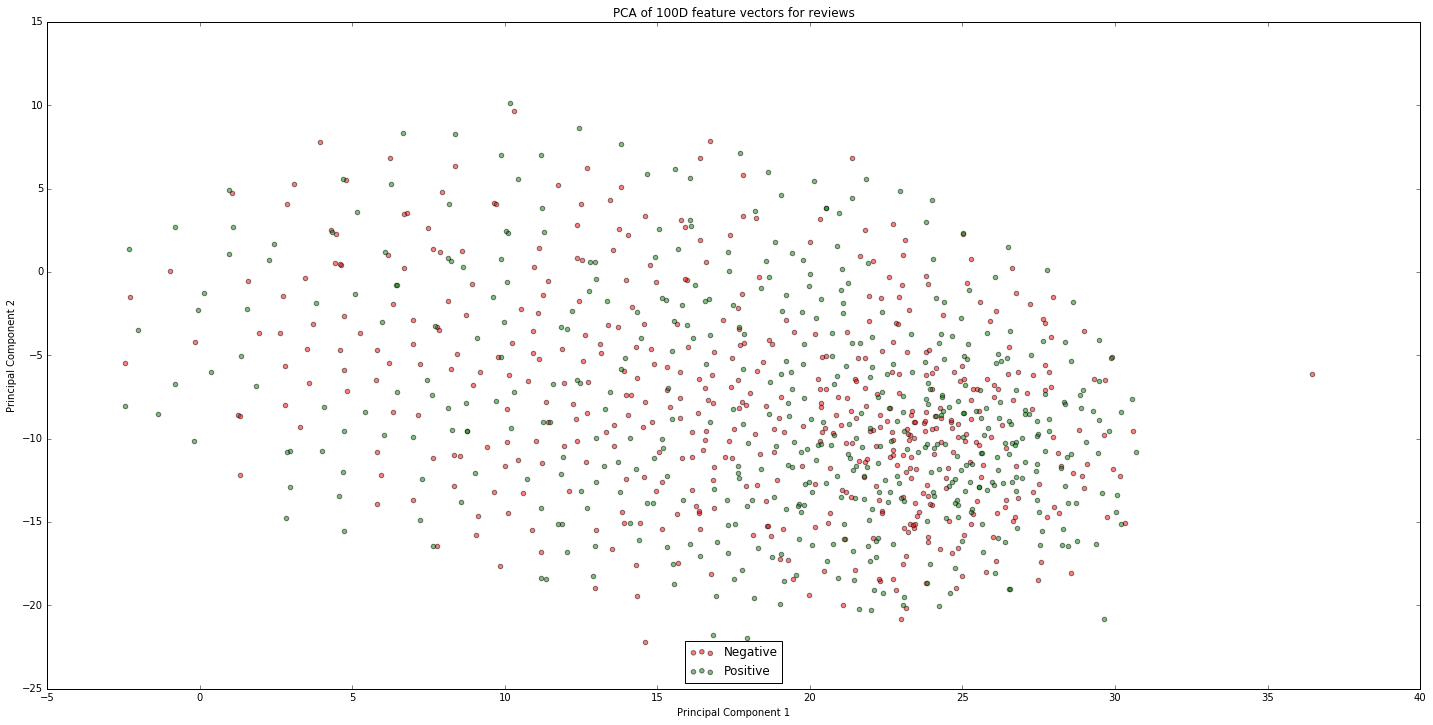

In [12]:
# PCA to project from 100 dimensions to 2 dimensions
%pylab inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

#pca = PCA(n_components=50)
#pca_50_r = pca.fit(X).transform(X)

tsne = TSNE(n_components=2, verbose=1)
X_r = tsne.fit_transform(X)

plt.style.context('seaborn-whitegrid')
plt.figure(figsize=(20,10))
for c, i, target_name in zip("rg", [0, 1], ['Negative', 'Positive']):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, alpha=0.5, label=target_name)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()
plt.title('PCA of 100D feature vectors for reviews')